In this project I am going to train and test Linear regression models with optimizations to predict house prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("housing.csv")

## Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int64
 6   guestroom         545 non-null    int64
 7   basement          545 non-null    int64
 8   hotwaterheating   545 non-null    int64
 9   airconditioning   545 non-null    int64
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int64
 12  furnishingstatus  545 non-null    int64
dtypes: int64(13)
memory usage: 55.5 KB


In [4]:
df.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

No nan, no categorical features, no need in managing them

Check correlations

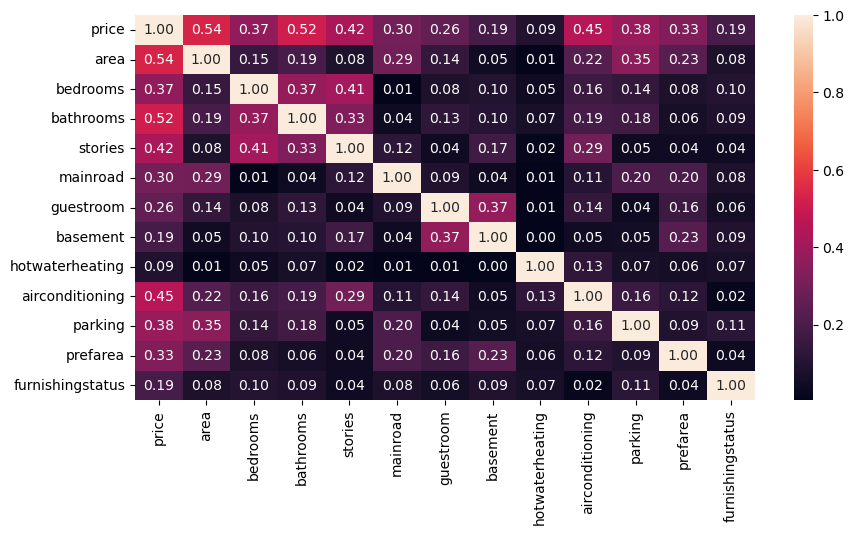

In [5]:
plt.figure(figsize=(10,5))
sns.heatmap(abs(df.corr()),annot=True,fmt=".2f")
plt.show()

There are some moderate correlations among features. It makes sense that area, bathrooms, and air conditioning are the most correlated with price. While area is a classic factor, bathrooms and air conditioning are also key comforts in a home

Check distributions

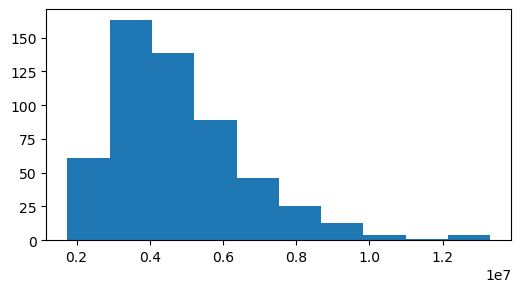

In [6]:
plt.figure(figsize=(6,3))
plt.hist(df.price)
plt.show()

<Figure size 640x480 with 0 Axes>

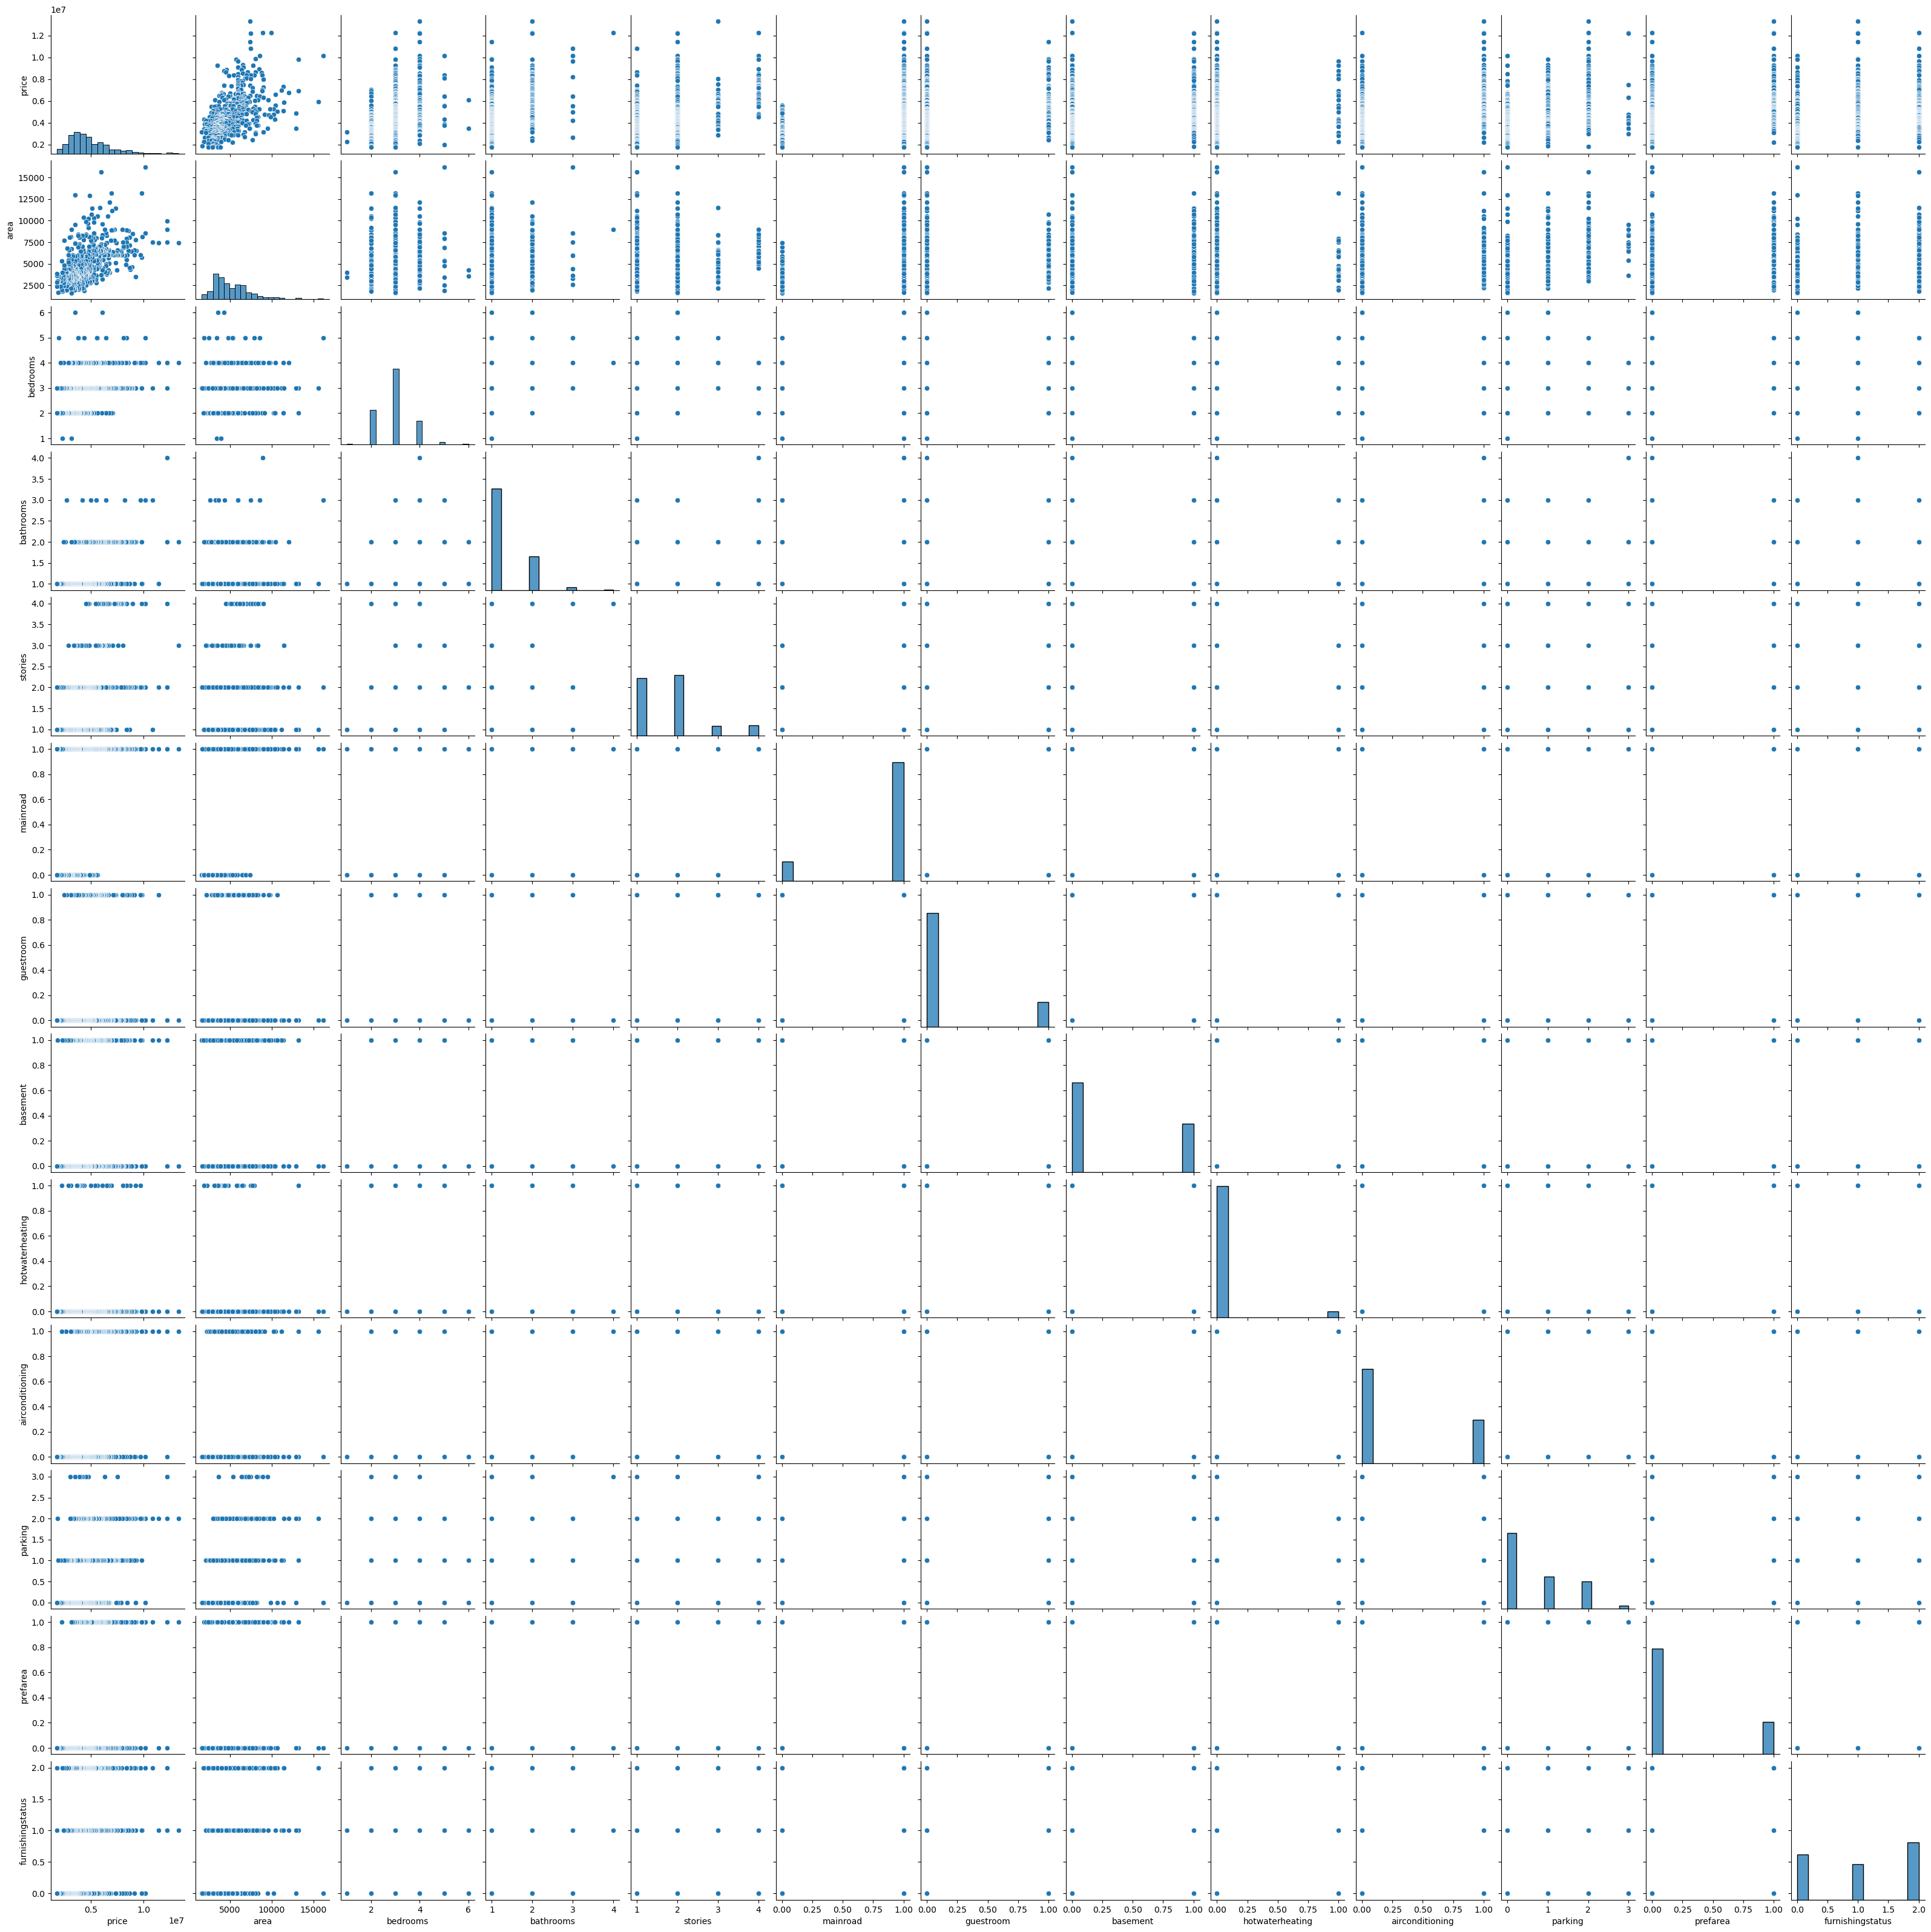

In [7]:
plt.figure()
sns.pairplot(df)
plt.show()

In [8]:
# I built this plot post hoc to check price distribution as a function its two-best correlated features:area and bathrooms
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=df.area, 
    y=df.bathrooms, 
    z=df.price, 
    mode='markers',
    marker=dict(size=5,
                color=df.price, 
                colorscale='Cividis',
                colorbar=dict(title='Price'))
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Area',
        yaxis_title='Bathrooms',
        zaxis_title='Price'
    ),
    title='Price vs Area and Bathrooms'
)

fig.show()

No anomalies detected

## Models

Since we have only 500 instances available, I'd rather use cross-validation to reduce overfitting

In [9]:
RANDOM_STATE = 42
X = df[df.columns[2:]]
y = df.price
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=RANDOM_STATE)

I'm gonna try regularization iperparameter tuning + polynomial features

I will start with a simple blind train and test as baseline score to understand my starting point

In [10]:
ls = Lasso()
ls.fit(X_train,y_train)
bl_rmse_train = np.sqrt(mean_squared_error(y_train,ls.predict(X_train)))
bl_rmse_test = np.sqrt(mean_squared_error(y_test,ls.predict(X_test)))
bl_r2_train = r2_score(y_train,ls.predict(X_train))
bl_r2_test = r2_score(y_test,ls.predict(X_test))
print(f"Blind RMSE score train: {bl_rmse_train:.4g}")
print(f"Blind R2 score train: {bl_r2_train:.2f}")
print(f"Blind RMSE score test: {bl_rmse_test:.4g}")
print(f"Blind R2 score test: {bl_r2_test:.2f}")

Blind RMSE score train: 1.1e+06
Blind R2 score train: 0.61
Blind RMSE score test: 1.306e+06
Blind R2 score test: 0.60


We can see there's no such overfitting yet, but we could achieve better scores

In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")

I wrote process_model to automate the training and testing process in order to fine tuning hyperparams

In [12]:
def process_model(model,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,show_resid=False,coef_vs_regularization=False,c_v_r_model = None,plot_index=0):  
    
    #set parameters tuning range
    param = {
        'model__alpha': np.logspace(-10, 10, 20),
        'poly__degree': np.arange(1,2)
    }

    #set pipeline
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('poly', PolynomialFeatures()),
        ('model', model)
    ])

    best_model_search = RandomizedSearchCV(pipe, param_distributions=param,n_iter=5, cv=3,
                                            random_state=RANDOM_STATE,scoring="r2")
    best_model_search.fit(X_train,y_train)
    best_model = best_model_search.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    #print best model scores and params
    print("Best params")
    print(best_model_search.best_params_)
    coefs = best_model.named_steps['model'].coef_
    for i,c in enumerate(coefs):
        print(f"c[{i}]: {coefs[i]:.4g}")
    print("intercept:", best_model.named_steps['model'].intercept_)
    print("Train score: ", f"{best_model_search.best_score_:.4g}")
    print("Train RMSE: ", f"{np.sqrt(mean_squared_error(y_train, y_train_pred)):.4g}")       
    print("Train R2: ", f"{r2_score(y_train, y_train_pred):.2f}")

    print("Test RMSE: ", f"{np.sqrt(mean_squared_error(y_test, y_test_pred)):.4g}")
    print("Test R2: ", f"{r2_score(y_test, y_test_pred):.2f}")
    
    if show_resid:
        # shows residual distribution
        plt.figure()
        sns.histplot(y_test-y_test_pred,bins=30)
        plt.xlabel("Price residual")
        plt.show()   
    
    if coef_vs_regularization:
        # shows the trend of coefficients with the regularization parameter
        coefs_ = {f"c[{i}]": [] for i in range(len(coefs))}
        coefs_["interc"] = []
        alpha_val = np.logspace(-6,8,20)
        
        for alpha in alpha_val:
            model = c_v_r_model(alpha)
            pipe = Pipeline([
                ('ss', StandardScaler()),
                ('poly', PolynomialFeatures(degree=1)),
                ('model', model)
                ])
            pipe.fit(X_train,y_train)
            coefs = pipe.named_steps['model'].coef_
            for i,c in enumerate(coefs):
                coefs_[f"c[{i}]"].append(coefs[i])
            coefs_["interc"].append(model.intercept_)
        plt.figure()
        sns.scatterplot(x=np.log10(alpha_val),y=coefs_[f"c[{plot_index}]"])
        plt.xlabel("log10(alpha)")
        plt.ylabel("coefficient")
        plt.title(f"{model.__class__.__name__} coefficients vs regularization")
        plt.show()

    return r2_score(y_test, y_test_pred)

I train all models and save scores to compare

In [13]:
r2_scores={}
print("Ridge")
r2_scores["Ridge"] = process_model(Ridge())
print("\n")
print("Lasso")
r2_scores["Lasso"] = process_model(Lasso(max_iter=1000))
print("\n")
for l1_ratio in np.linspace(.2,.8,4):
    print("ElasticNet l1 ratio: ",f"{l1_ratio:.1f}")
    r2_scores[f"ElasticNet {{l1_ratio:.1f}}"] = process_model(ElasticNet(l1_ratio))
    print("\n")

Ridge
Best params
{'poly__degree': 1, 'model__alpha': 0.026366508987303555}
c[0]: 0
c[1]: 1.069e+05
c[2]: 6.022e+05
c[3]: 3.105e+05
c[4]: 2.724e+05
c[5]: 1.822e+05
c[6]: 1.791e+05
c[7]: 1.45e+05
c[8]: 4.081e+05
c[9]: 3.838e+05
c[10]: 2.854e+05
c[11]: 1.057e+05
intercept: 4762406.272965879
Train score:  0.5663
Train RMSE:  1.1e+06
Train R2:  0.61
Test RMSE:  1.306e+06
Test R2:  0.60


Lasso
Best params
{'poly__degree': 1, 'model__alpha': 0.026366508987303555}
c[0]: 0
c[1]: 1.068e+05
c[2]: 6.022e+05
c[3]: 3.105e+05
c[4]: 2.724e+05
c[5]: 1.822e+05
c[6]: 1.791e+05
c[7]: 1.45e+05
c[8]: 4.081e+05
c[9]: 3.838e+05
c[10]: 2.854e+05
c[11]: 1.057e+05
intercept: 4762406.272965879
Train score:  0.5663
Train RMSE:  1.1e+06
Train R2:  0.61
Test RMSE:  1.306e+06
Test R2:  0.60


ElasticNet l1 ratio:  0.2
Best params
{'poly__degree': 1, 'model__alpha': 0.026366508987303555}
c[0]: 0
c[1]: 1.107e+05
c[2]: 5.948e+05
c[3]: 3.083e+05
c[4]: 2.707e+05
c[5]: 1.818e+05
c[6]: 1.778e+05
c[7]: 1.431e+05
c[8]: 4.05

No such score enhancements til now

Try selecting features basing on correlation with price

In [22]:
features = [item for item in df.corr().price[df.corr().price >= .37].index if item != 'price']
features

['area', 'bathrooms', 'stories', 'airconditioning', 'parking']

In [23]:
X = df[features]
y = df.price
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=RANDOM_STATE)

In [31]:
r2_scores={}
print("Ridge")
r2_scores["Ridge"] = process_model(Ridge(),X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
print("\n")
print("Lasso")
r2_scores["Lasso"] = process_model(Lasso(max_iter=1000),X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
print("\n")
for l1_ratio in np.linspace(.2,.8,4):
    print("ElasticNet l1 ratio: ",f"{l1_ratio:.1f}")
    r2_scores[f"ElasticNet {l1_ratio:.1f}"] = process_model(ElasticNet(l1_ratio),X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    print("\n")

Ridge
Best params
{'poly__degree': 1, 'model__alpha': 0.026366508987303555}
c[0]: 0
c[1]: 6.608e+05
c[2]: 5.777e+05
c[3]: 3.357e+05
c[4]: 3.734e+05
c[5]: 3.007e+05
intercept: 4762406.272965879
Train score:  0.5793
Train RMSE:  1.102e+06
Train R2:  0.61
Test RMSE:  1.348e+06
Test R2:  0.58


Lasso
Best params
{'poly__degree': 1, 'model__alpha': 1e-10}
c[0]: 0
c[1]: 6.609e+05
c[2]: 5.777e+05
c[3]: 3.357e+05
c[4]: 3.734e+05
c[5]: 3.007e+05
intercept: 4762406.272965879
Train score:  0.5793
Train RMSE:  1.102e+06
Train R2:  0.61
Test RMSE:  1.348e+06
Test R2:  0.58


ElasticNet l1 ratio:  0.2
Best params
{'poly__degree': 1, 'model__alpha': 0.026366508987303555}
c[0]: 0
c[1]: 6.539e+05
c[2]: 5.724e+05
c[3]: 3.341e+05
c[4]: 3.718e+05
c[5]: 3e+05
intercept: 4762406.272965879
Train score:  0.5796
Train RMSE:  1.102e+06
Train R2:  0.61
Test RMSE:  1.348e+06
Test R2:  0.58


ElasticNet l1 ratio:  0.4
Best params
{'poly__degree': 1, 'model__alpha': 0.026366508987303555}
c[0]: 0
c[1]: 6.539e+05
c[2

In [32]:
print("SGD")
process_model(SGDRegressor(learning_rate="adaptive"))

SGD
Best params
{'poly__degree': 1, 'model__alpha': 0.026366508987303555}
c[0]: 1.489e+06
c[1]: 1.144e+05
c[2]: 5.914e+05
c[3]: 3.072e+05
c[4]: 2.69e+05
c[5]: 1.801e+05
c[6]: 1.746e+05
c[7]: 1.427e+05
c[8]: 3.999e+05
c[9]: 3.771e+05
c[10]: 2.812e+05
c[11]: 1.046e+05
intercept: [3253723.80269126]
Train score:  0.5677
Train RMSE:  1.1e+06
Train R2:  0.61
Test RMSE:  1.306e+06
Test R2:  0.60


0.6039828499395262

No enhancements still with these models. There's no way having better predictions with such simple models.

## Visualization and Evaluation

R2 score model plot

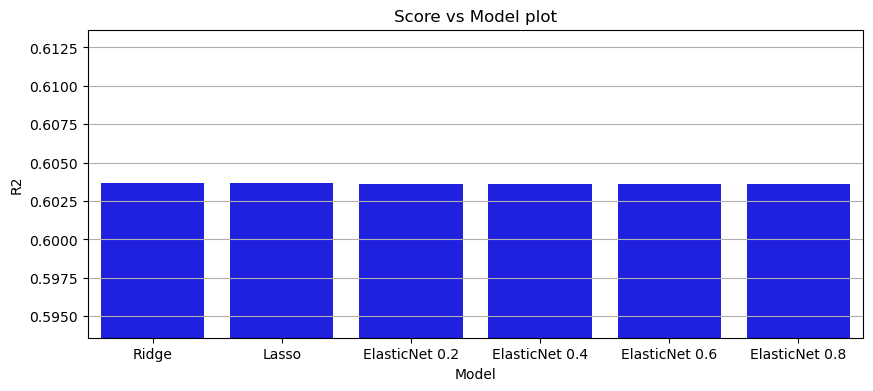

In [18]:
plt.figure(figsize=(10,4))
sns.barplot(r2_scores,color="b")
plt.ylim(np.min(list(r2_scores.values()))-.01,np.max(list(r2_scores.values()))+.01)
plt.xlabel("Model")
plt.ylabel("R2")
plt.title("Score vs Model plot")
plt.grid(axis = "y")
plt.show()

Models perform equally

Residual distribution

Ridge
Best params
{'poly__degree': 1, 'model__alpha': 0.026366508987303555}
c[0]: 0
c[1]: 1.069e+05
c[2]: 6.022e+05
c[3]: 3.105e+05
c[4]: 2.724e+05
c[5]: 1.822e+05
c[6]: 1.791e+05
c[7]: 1.45e+05
c[8]: 4.081e+05
c[9]: 3.838e+05
c[10]: 2.854e+05
c[11]: 1.057e+05
intercept: 4762406.272965879
Train score:  0.5663
Train RMSE:  1.1e+06
Train R2:  0.61
Test RMSE:  1.306e+06
Test R2:  0.60


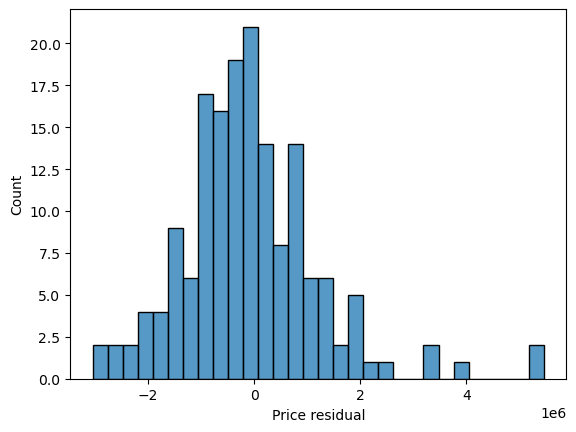

0.6036558468672323

In [19]:
print("Ridge")
process_model(Ridge(),show_resid=True)

Residual distribution is quite gaussian, no anomaly detected

Hyperparams vs regularizzation

Best params
{'poly__degree': 1, 'model__alpha': 0.026366508987303555}
c[0]: 0
c[1]: 1.068e+05
c[2]: 6.022e+05
c[3]: 3.105e+05
c[4]: 2.724e+05
c[5]: 1.822e+05
c[6]: 1.791e+05
c[7]: 1.45e+05
c[8]: 4.081e+05
c[9]: 3.838e+05
c[10]: 2.854e+05
c[11]: 1.057e+05
intercept: 4762406.272965879
Train score:  0.5663
Train RMSE:  1.1e+06
Train R2:  0.61
Test RMSE:  1.306e+06
Test R2:  0.60


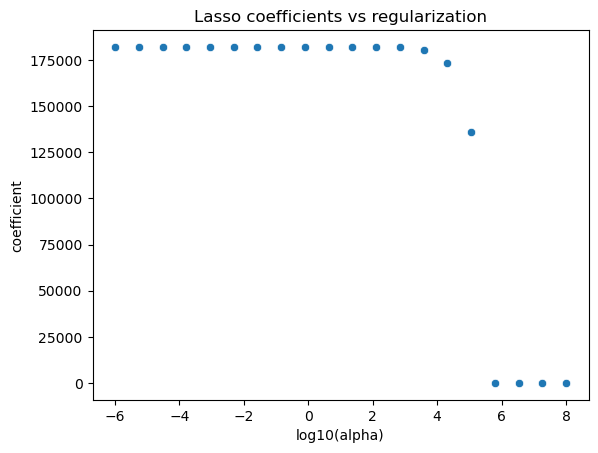

0.6036558796752243

In [20]:
process_model(Lasso(),coef_vs_regularization=True,c_v_r_model=Lasso,plot_index=5)

Can be observed that each parameter exhibits two convergence values depending on the regularization parameter: one with alpha -> 0 and the other alpha -> infinity. Specifically, c[0] corresponds to the single-term column generated by PolynomialFeatures and has zero weight. Among the two solutions for coefficient stability, the one with parameters alpha-> 0 achieves a lower loss and gives a better model